In [1]:
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pathlib import Path
from itertools import product

from utilities.nn_utils import *
from IPython.display import display, Markdown

In [2]:
data_path = Path("/Users/adamsulik/Workspace/qrt_datachallenge/data")

output_storage_path = data_path.parent / 'outputs' / 'nn_approach'
output_storage_path.mkdir(exist_ok=True, parents=True)

# Read data

In [3]:
x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv(data_path / 'x_test_c7ETL4q.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


# Feature engineering

In [4]:
def column2onehot(x_table, column, ohencoder=None):
    if ohencoder is None:
        ohencoder = OneHotEncoder().fit(x_table[column].values.reshape(-1, 1))
    ohe_values = ohencoder.transform(x_table[column].values.reshape(-1, 1)).toarray()
    column_names = [f'{column}_ohe_{i}' for i in range(ohe_values.shape[1])]
    ohe_df = pd.DataFrame(index=x_table.index, columns=column_names)
    ohe_df.iloc[:] = ohe_values
    return ohe_df, ohencoder

# Run the training

In [ ]:
SEED = 42

backdates = [1, 3, 5, 10, 20]
rel_cat_cols = ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY']

for backdate_range, used_oh_col in product(backdates, rel_cat_cols):
    experiment_name = f'oh-{used_oh_col}_daysback-{backdate_range}'
    display(Markdown('---'))
    display(Markdown(f'# Experiment: {experiment_name}'))
    display(Markdown(f'OH encoding: {used_oh_col}'))
    display(Markdown(f'Looking back for {backdate_range} dates\n'))
    
    chosen_field_oh, ohencoder = column2onehot(train, used_oh_col)
    
    numerical_columns = [f'RET_{i+1}' for i in range(backdate_range)] + [f'VOLUME_{i+1}' for i in range(backdate_range)]
    oh_columns = list(chosen_field_oh.columns)
    
    x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)
    x_df = x_df[numerical_columns + oh_columns] # assert order
    
    X = x_df.values
    Y = train['RET'].astype(int).values
    
    # Standarize numerical values
    scaler = StandardScaler().fit(X[:, :len(numerical_columns)])
    X[:, :len(numerical_columns)] = scaler.transform(X[:, :len(numerical_columns)])
    
    # run k-fold cv
    cv_results = run_k_fold_training(X, Y, random_seed=SEED)
    
    # store cross validation results
    cv_results = pd.DataFrame(cv_results).set_index('fold')
    cv_results.to_csv(output_storage_path / f'{experiment_name}.csv')
    
    avg_acc = cv_results['accuracy'].mean()
    std_acc = cv_results['accuracy'].std()
    
    upper_bound_acc = avg_acc + std_acc
    lower_bound_acc = avg_acc - std_acc
    
    print(f'Accuracy: {avg_acc:.5f} [{lower_bound_acc:.5f}; {upper_bound_acc:.5f}] (+- {std_acc:.6f}), based on 4 kfolds')

---

# Experiment: oh-SECTOR_daysback-1

OH encoding: SECTOR

Looking back for 1 dates


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_30826/1528319313.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


Training on mps

Fold 1


# Plot results

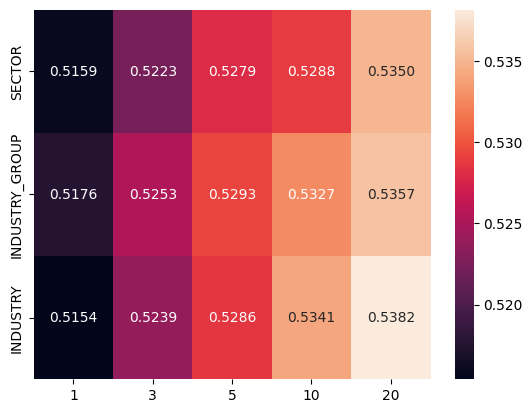

In [5]:
# load outcomes and procsess it

backdates = [1, 3, 5, 10, 20]
rel_cat_cols = ['SECTOR', 'INDUSTRY_GROUP', 'INDUSTRY']

acc_df = pd.DataFrame(index=rel_cat_cols, columns=backdates, dtype=float)

for backdate_range, used_oh_col in product(backdates, rel_cat_cols):
    experiment_name = f'oh-{used_oh_col}_daysback-{backdate_range}'
    results_df = pd.read_csv(output_storage_path / f'{experiment_name}.csv')
    acc_df.loc[used_oh_col, backdate_range] = results_df['accuracy'].mean()
    
f, ax = plt.subplots()
sns.heatmap(acc_df, annot=True, fmt='.4f')
plt.show()

# Pick and train the best model

In [13]:
EPOCHS = 100
BATCH_SIZE = 64
SEED = 42
VAL_SPLIT = 0.1

best_backdate = 10
best_cat_col = 'INDUSTRY'

bestmodel_exp_name = f'best_model_{best_cat_col}-{best_backdate}days'

chosen_field_oh, ohencoder = column2onehot(train, best_cat_col)
with open(output_storage_path / f'{bestmodel_exp_name}_ohencoder.pkl', 'wb') as f:
    pickle.dump(ohencoder, f)
    
numerical_columns = [f'RET_{i+1}' for i in range(best_backdate)] + [f'VOLUME_{i+1}' for i in range(best_backdate)]
oh_columns = list(chosen_field_oh.columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)
x_df = x_df[numerical_columns + oh_columns] # assert order

X = x_df.values
Y = train['RET'].astype(int).values

model_checkpoint, model_stats_df = full_dataset_training(
    X=X, Y=Y,
    numerical_columns=numerical_columns,
    output_storage_path=output_storage_path,
    bestmodel_exp_name=bestmodel_exp_name,
    val_split=VAL_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    seed=SEED
)

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_28547/512643079.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = train[numerical_columns].join(chosen_field_oh).fillna(0)


11:33:51	  -- Epoch 10: 	Training Loss = 0.6901 | Training Accuracy = 0.5329 | Validation Loss = 0.6906 | Validation Accuracy = 0.5289
11:34:25	  -- Epoch 20: 	Training Loss = 0.6890 | Training Accuracy = 0.5371 | Validation Loss = 0.6899 | Validation Accuracy = 0.5303
11:34:59	  -- Epoch 30: 	Training Loss = 0.6883 | Training Accuracy = 0.5399 | Validation Loss = 0.6893 | Validation Accuracy = 0.5323
11:35:34	  -- Epoch 40: 	Training Loss = 0.6881 | Training Accuracy = 0.5402 | Validation Loss = 0.6891 | Validation Accuracy = 0.5333
11:36:08	  -- Epoch 50: 	Training Loss = 0.6875 | Training Accuracy = 0.5423 | Validation Loss = 0.6892 | Validation Accuracy = 0.5300
11:36:42	  -- Epoch 60: 	Training Loss = 0.6877 | Training Accuracy = 0.5420 | Validation Loss = 0.6903 | Validation Accuracy = 0.5292
11:37:15	  -- Epoch 70: 	Training Loss = 0.6878 | Training Accuracy = 0.5416 | Validation Loss = 0.6894 | Validation Accuracy = 0.5320
11:37:49	  -- Epoch 80: 	Training Loss = 0.6873 | Train

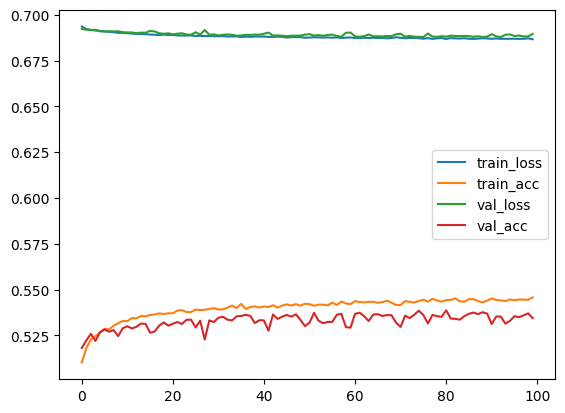

In [14]:
model_stats_df.plot()
plt.show()

# Run the trained model on eval set

In [15]:
# setup variables
best_backdate = 10
best_cat_col = 'INDUSTRY'
bestmodel_exp_name = f'best_model_{best_cat_col}-{best_backdate}days'
print(bestmodel_exp_name)
checkpoint_path = output_storage_path / f'{bestmodel_exp_name}.pt'

# preprocess data
with open(output_storage_path / f'{bestmodel_exp_name}_ohencoder.pkl', 'rb') as f:
    ohencoder = pickle.load(f)
    
eval_chosen_field_oh, _ = column2onehot(train, best_cat_col, ohencoder=ohencoder)
numerical_columns = [f'RET_{i+1}' for i in range(best_backdate)] + [f'VOLUME_{i+1}' for i in range(best_backdate)]
oh_columns = list(eval_chosen_field_oh.columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_eval_df = test[numerical_columns].join(eval_chosen_field_oh).fillna(0)
x_eval_df = x_eval_df[numerical_columns + oh_columns] # assert order

X_eval = x_eval_df.values

preds = load_model_and_predict(checkpoint_path, X_eval, numerical_columns, batch_size=32)

test_with_preds = test.copy()
test_with_preds['preds'] = preds
test_with_preds['RET'] = test_with_preds['preds'] > 0.5
test_with_preds

best_model_INDUSTRY-10days


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_28547/1617654781.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_eval_df = test[numerical_columns].join(eval_chosen_field_oh).fillna(0)
/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/nn_utils.py:400: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpicklin

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,preds,RET
ID,,,,,,,,,,,,,,,,,,,,,
418595,2,0,37,12,5,94,0.020208,0.146176,0.010059,0.224756,...,-0.001035,-0.416533,-0.000148,-0.004548,-0.000148,-0.161792,0.016997,-0.007221,0.533923,True
418596,2,1,15,4,3,37,0.009134,-0.251631,0.021913,-0.712515,...,-0.001544,-0.408979,0.001546,0.396372,-0.007875,-0.431760,0.001742,-0.574228,0.529249,True
418597,2,4,57,20,8,142,0.005008,-0.115845,0.005914,-0.107441,...,0.011481,-0.536967,0.009520,-0.368585,0.000000,0.022713,-0.002066,-0.207362,0.501574,True
418598,2,5,35,12,5,91,0.015370,-0.090295,-0.013738,0.048465,...,0.037018,0.665132,-0.003097,0.141991,-0.008191,-0.172382,0.005145,-0.353172,0.494081,False
418599,2,6,57,20,8,142,0.011419,-0.289027,0.022807,-0.262690,...,0.004304,-0.506291,-0.026469,-0.280666,0.010743,0.365773,-0.011134,0.933284,0.482629,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617019,222,5707,52,18,7,122,0.010188,-0.476830,-0.006419,-0.534137,...,0.019115,0.361119,-0.002090,-0.132224,0.015389,-0.014298,-0.008680,0.128657,0.520971,True
617020,222,5710,33,10,4,83,-0.000838,-0.063269,-0.026928,0.532781,...,0.032965,0.108639,0.013488,-0.458271,0.019894,-0.353293,0.013513,-0.219671,0.519737,True
617021,222,5714,49,17,7,113,0.005941,-0.506350,-0.016363,-0.173802,...,0.002121,1.087437,-0.012910,1.791362,-0.057857,6.330687,-0.000493,1.175063,0.501884,True


# Save the outcomes

In [16]:
test_with_preds['RET'].reset_index().to_csv(output_storage_path / 'naive_nn_asulik_submission2.csv', index=False)